<a href="https://colab.research.google.com/github/Ishat2038/Siamese-Neural-Networks-with-Triplet-Loss-and-SVM-Classifier-for-Human-Action-Recognition/blob/main/Siamese_Triplet_Embedding_for_HAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Mount Google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### **Import libraries**

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.layers import Input, Add, Dropout, Dense, Activation,Conv2D, MaxPooling2D, Flatten,ZeroPadding2D, BatchNormalization, Flatten, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split  # For data splitting (if applicable)
import os, glob
from google.colab.patches import cv2_imshow
import pandas as pd
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from keras import backend as k
#from keras.models import Model, Sequential, load_model
from PIL import Image # For handling the images
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### **Data Loading and Triplet Generator Definition (TripletGenerator class)**

Number of total gestures are : 4
anchor path is : /content/drive/MyDrive/HGR_dataset/dataset_p/0/004/004_7.png
positive path is : /content/drive/MyDrive/HGR_dataset/dataset_p/0/001/001_24.png
negative path is : /content/drive/MyDrive/HGR_dataset/dataset_p/1/104/104_25.png
/content/drive/MyDrive/HGR_dataset/dataset_p/0/004/004_7.png
/content/drive/MyDrive/HGR_dataset/dataset_p/0/001/001_24.png
/content/drive/MyDrive/HGR_dataset/dataset_p/1/104/104_25.png


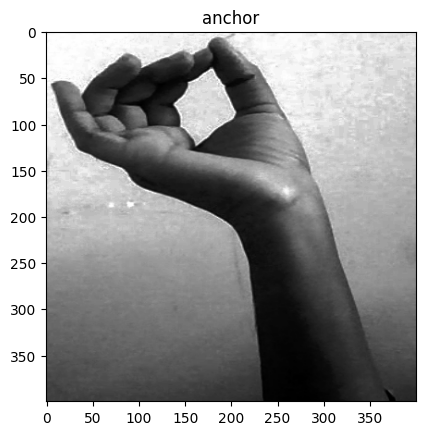

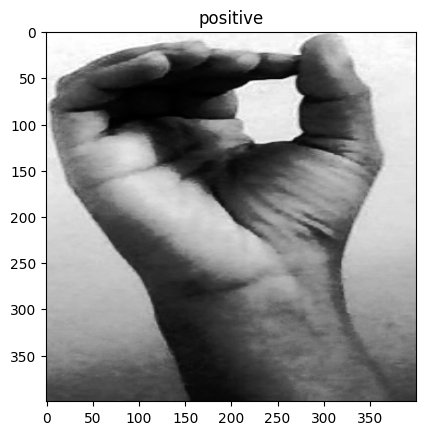

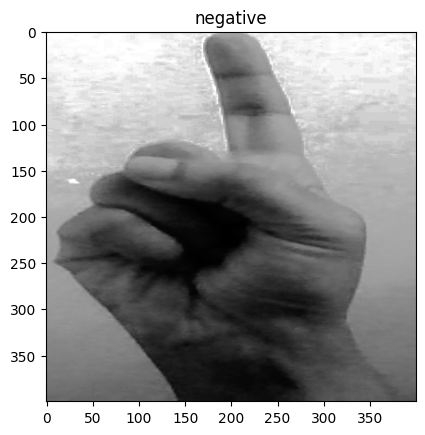

In [ ]:
import os
import random
import glob
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Define paths and dataset structure
dataset_path = "/content/drive/MyDrive/HGR_dataset/dataset_p"  # Path to the dataset folder
gesture_classes = sorted(os.listdir(dataset_path))  # List of gesture class folders
frames_per_video = 60  # Number of frames per video

# Function to extract frame index from filename
def extract_frame_index(frame_path):
    filename = os.path.basename(frame_path)  # Extract the filename from the path
    frame_index = int(filename.split("_")[-1].split(".")[0])  # Split by "_", extract index, convert to int
    return frame_index

# Function to create triplets from a single gesture class
def create_triplets_from_class(gesture_class):
  video_folders = sorted(os.listdir(os.path.join(dataset_path, gesture_class)))
  frames = []
  num_of_gesture=0
  # print(os.path.join(dataset_path, gesture_class, video_folders[0], "*.png"))
  # print(video_folders[0])
  for video_folder in video_folders:
    frames.extend([
        (extract_frame_index(frame_path), frame_path)
        for frame_path in glob.glob(os.path.join(dataset_path, gesture_class, video_folder, "*.png"))
    ])  # Collect all frame paths and indices
    num_of_gesture += 1
  print("Number of total gestures are :", num_of_gesture)

  while True:  # Generate triplets indefinitely
    #generating anchors
    anchor_class = random.choice(gesture_classes)
    anchor_video_folder = random.choice(os.listdir(os.path.join(dataset_path, anchor_class)))
    anchor_index = random.randrange(frames_per_video)  # Ensure valid range
    anchor_path = os.path.join(dataset_path, anchor_class, anchor_video_folder, f'{anchor_video_folder}_{anchor_index}.png')
    print("anchor path is :", anchor_path)

    #generating positives
    positive_class = anchor_class
    positive_video_folder = random.choice(os.listdir(os.path.join(dataset_path, positive_class)))
    positive_index = random.randrange(1, frames_per_video)  # Positive from same video, different frame
    if positive_video_folder == anchor_video_folder and positive_index == anchor_index:
      positive_video_folder = random.choice(os.listdir(os.path.join(dataset_path, positive_class)))
      positive_index = random.randrange(frames_per_video)  # Positive from same video, different frame
      #positive_path = os.path.join(dataset_path, positive_class, positive_video_folder, f'{positive_video_folder}_{positive_index}.png')
    positive_path = os.path.join(dataset_path, positive_class, positive_video_folder, f'{positive_video_folder}_{positive_index}.png')
    print("positive path is :", positive_path)

    #generating negatives
    negative_class = random.choice(gesture_classes)
    while negative_class == anchor_class:  # Ensure negative is from a different class
      negative_class = random.choice(gesture_classes)

    negative_video_folder = random.choice(os.listdir(os.path.join(dataset_path, negative_class)))
    negative_index = random.randrange(1, frames_per_video)  # Random frame from the negative video
    negative_path = os.path.join(dataset_path, negative_class, negative_video_folder, f'{negative_video_folder}_{negative_index}.png')
    print("negative path is :", negative_path)

    path_list=[]
    # Load images using paths, handling missing frames
    try:
      # anchor = load_image(anchor_path)
      # positive = load_image(positive_path)
      # negative = load_image(negative_path)
      path_list.append(anchor_path)
      path_list.append(positive_path)
      path_list.append(negative_path)
      # yield [anchor, positive, negative]
      return path_list
    except FileNotFoundError:
      print(f"Skipping triplet due to missing frame: {negative_path}")
      #breakpoint

# Function to load an image (adapt based on your pre-processing needs)
def load_image(path):
  try:
    img = keras.preprocessing.image.load_img(path, target_size=(400, 400), color_mode="grayscale")
    img_array = keras.preprocessing.image.img_to_array(img)
    img_batch = np.expand_dims(img_array, axis=0)  # Add batch dimension
    return img_batch
  except FileNotFoundError:
    raise FileNotFoundError(f"Image not found: {path}") from None  # Re-raise with original path

# Generate triplets and visualize a batch
triplet_generator = create_triplets_from_class(gesture_classes[0])  # Example usage
# batch = [next(triplet_generator) for _ in range(3)]  # Sample a batch of 3 triplets

# for i in range(len(triplet_generator)):
#   anchor, positive, negative = batch[i]

#   plt.figure(figsize=(12, 4))
#   plt.subplot(131)
#   plt.imshow(anchor[0, :, :, 0], cmap='gray')
#   plt.imshow(positive[0, :, :, 0], cmap='gray')
#   plt.imshow(negative[0, :, :, 0], cmap='gray')

anchor_path=triplet_generator[0]
positive_path=triplet_generator[1]
negative_path=triplet_generator[2]

print(anchor_path)
print(positive_path)
print(negative_path)

anchor = cv2.imread(anchor_path)
positive = cv2.imread(positive_path)
negative = cv2.imread(negative_path)

def debug_imshow(title, image, waitKey=False):
  plt.figure()
  plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
  plt.title(title)
  plt.show()

debug_imshow("anchor", anchor)
debug_imshow("positive", positive)
debug_imshow("negative", negative)

### **Base CNN Model Definition**

In [ ]:
def create_base_cnn_model(input_shape):
    """
    Creates a base CNN model for the Siamese network.

    Args:
        input_shape: The shape of the input images (height, width, channels).

    Returns:
        A Keras Model representing the base CNN.
    """
    model = Sequential()

    # Convolutional layers
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))

    # Flatten the output
    model.add(Flatten())

    # Dense layers for embedding
    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dense(64, activation='linear')) # Embedding size of 64

    return model

# Example usage (not part of the subtask, but for testing)
# input_shape = (400, 400, 1) # Assuming grayscale images
# base_model = create_base_cnn_model(input_shape)
# base_model.summary()

### **Triplet Loss Function Definition**

In [ ]:
import tensorflow.keras.backend as K

def triplet_loss(anchor, positive, negative, margin=0.2):
    """
    Calculates the triplet loss.

    Args:
        anchor: Embedding vector for the anchor image.
        positive: Embedding vector for the positive image.
        negative: Embedding vector for the negative image.
        margin: The margin value for the triplet loss.

    Returns:
        The calculated triplet loss.
    """
    # Calculate Euclidean distance between anchor and positive
    pos_distance = K.sqrt(K.sum(K.square(anchor - positive), axis=-1))

    # Calculate Euclidean distance between anchor and negative
    neg_distance = K.sqrt(K.sum(K.square(anchor - negative), axis=-1))

    # Calculate the triplet loss
    loss = K.maximum(0.0, pos_distance - neg_distance + margin)

    return loss

### **Siamese Network Construction**

In [ ]:
from tensorflow.keras.layers import Input

# Define input layers for anchor, positive, and negative images
input_shape = (400, 400, 1)
anchor_input = Input(shape=input_shape, name='anchor_input')
positive_input = Input(shape=input_shape, name='positive_input')
negative_input = Input(shape=input_shape, name='negative_input')

# Get the base CNN model
base_cnn_model = create_base_cnn_model(input_shape)

# Get embeddings for each input
anchor_embedding = base_cnn_model(anchor_input)
positive_embedding = base_cnn_model(positive_input)
negative_embedding = base_cnn_model(negative_input)

# Combine the embeddings using a Lambda layer and the triplet loss function
triplet_loss_layer = tf.keras.layers.Lambda(triplet_loss, output_shape=(), name='triplet_loss_layer')([anchor_embedding, positive_embedding, negative_embedding])

# Create the Siamese model
siamese_model = Model(inputs=[anchor_input, positive_input, negative_input], outputs=triplet_loss_layer)

# The model can now be compiled and trained
# siamese_model.compile(optimizer='adam', loss=None) # Loss is already defined in the Lambda layer
siamese_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor_input        │ (None, 400, 400,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive_input      │ (None, 400, 400,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative_input      │ (None, 400, 400,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64)        │ 37,851,200 │ anchor_input[0][… │
│ (Sequential)        │                   │            │ positive_input[0… │
│                     │                   │            │ negative_input[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ triplet_loss_layer  │ (None)            │          0 │ sequential[0][0], │
│ (Lambda)            │                   │            │ sequential[1][0], │
│                     │                   │            │ sequential[2][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 37,851,200 (144.39 MB)

 Trainable params: 37,850,496 (144.39 MB)

 Non-trainable params: 704 (2.75 KB)

### **Create a Data Generator for Triplets**

In [ ]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import random
import glob

class TripletGenerator(keras.utils.Sequence):
    def __init__(self, dataset_path, gesture_classes, frames_per_video, batch_size, image_size=(400, 400), color_mode="grayscale"):
        self.dataset_path = dataset_path
        self.gesture_classes = gesture_classes
        self.frames_per_video = frames_per_video
        self.batch_size = batch_size
        self.image_size = image_size
        self.color_mode = color_mode
        self.data = self._load_data()

    def _load_data(self):
        data = {}
        for gesture_class in self.gesture_classes:
            video_folders = sorted(os.listdir(os.path.join(self.dataset_path, gesture_class)))
            data[gesture_class] = []
            for video_folder in video_folders:
                frame_paths = sorted(glob.glob(os.path.join(self.dataset_path, gesture_class, video_folder, "*.png")))
                data[gesture_class].extend(frame_paths)
        return data

    def __len__(self):
        # Calculate the number of batches per epoch. This is an estimate.
        # A more accurate calculation might be needed depending on your sampling strategy.
        return int(np.floor(sum(len(paths) for paths in self.data.values()) / self.batch_size))

    def __getitem__(self, index):
        anchor_images = []
        positive_images = []
        negative_images = []

        while len(anchor_images) < self.batch_size:
            # Select anchor
            anchor_class = random.choice(self.gesture_classes)
            anchor_path = random.choice(self.data[anchor_class])
            anchor_img = self._load_image(anchor_path)

            # Select positive (from the same class)
            positive_path = random.choice(self.data[anchor_class])
            while positive_path == anchor_path:
                positive_path = random.choice(self.data[anchor_class])
            positive_img = self._load_image(positive_path)

            # Select negative (from a different class)
            negative_class = random.choice(self.gesture_classes)
            while negative_class == anchor_class:
                negative_class = random.choice(self.gesture_classes)
            negative_path = random.choice(self.data[negative_class])
            negative_img = self._load_image(negative_path)

            # Only append if all images were loaded successfully
            if anchor_img is not None and positive_img is not None and negative_img is not None:
                anchor_images.append(anchor_img)
                positive_images.append(positive_img)
                negative_images.append(negative_img)


        return [np.array(anchor_images), np.array(positive_images), np.array(negative_images)], None # Return None for labels as triplet loss is unsupervised


    def _load_image(self, path):
        try:
            img = keras.preprocessing.image.load_img(path, target_size=self.image_size, color_mode=self.color_mode)
            img_array = keras.preprocessing.image.img_to_array(img)
            # img_array = np.expand_dims(img_array, axis=0)  # No need for batch dimension here
            return img_array
        except (FileNotFoundError, Exception) as e:
            print(f"Warning: Error loading image {path}: {e}. Skipping.")
            return None # Or handle this case as appropriate

# Example usage (assuming dataset_path and gesture_classes are defined)
dataset_path = "/content/drive/MyDrive/HGR_dataset/dataset_p"
gesture_classes = sorted(os.listdir(dataset_path))
frames_per_video = 60
batch_size = 16

train_generator = TripletGenerator(dataset_path, gesture_classes, frames_per_video, batch_size)

# You can test the generator by getting a batch
# batch = train_generator[0]
# print(f"Shape of anchor batch: {batch[0].shape}")
# print(f"Shape of positive batch: {batch[1].shape}")
# print(f"Shape of negative batch: {batch[2].shape}")

### **Siamese Network Training (with ModelCheckpoint)**

### **Compile the Siamese Model**

In [ ]:
# Compile the Siamese model
siamese_model.compile(optimizer='adam', loss=None) # Loss is already defined in the Lambda layer

# Train the model
epochs = 10  # Define the number of epochs
steps_per_epoch = len(train_generator) # Calculate steps per epoch

history = siamese_model.fit(
    train_generator,
    epochs=epochs,
    steps_per_epoch=steps_per_epoch
)

### **Embedding Model Creation**

In [ ]:
# Create a model that outputs the embeddings from the base CNN
embedding_model = Model(inputs=base_cnn_model.input, outputs=base_cnn_model.output)
embedding_model.summary()

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ anchor_input (InputLayer)       │ (None, 400, 400, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 64)             │    37,851,200 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,851,200 (144.39 MB)

 Trainable params: 37,850,496 (144.39 MB)

 Non-trainable params: 704 (2.75 KB)

### **Embedding Visualization (t-SNE)**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


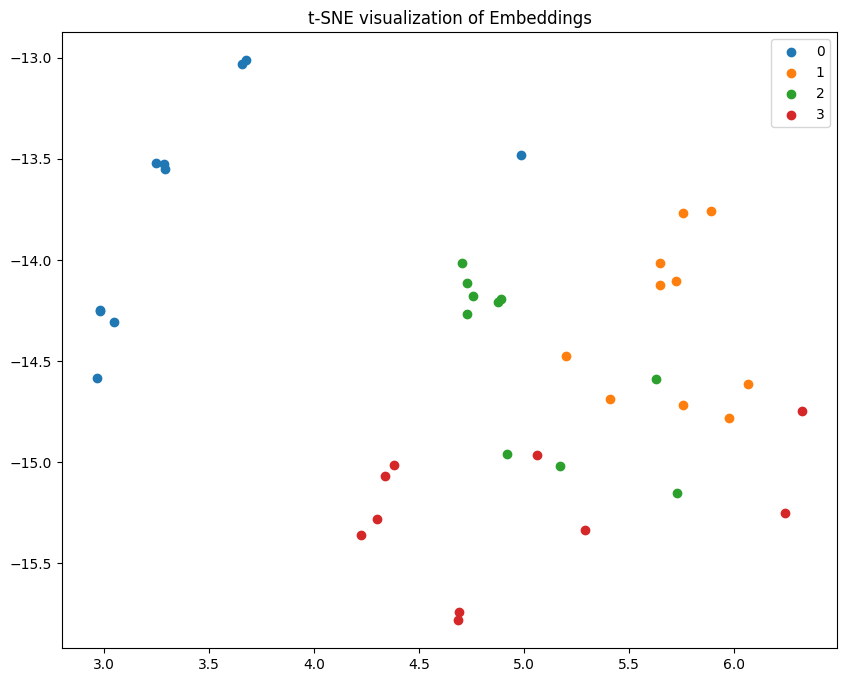

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

# Select a subset of images for evaluation
eval_images = []
eval_labels = []
num_images_per_class = 10 # Number of images to select per class

for gesture_class in gesture_classes:
    class_paths = train_generator.data[gesture_class]
    selected_paths = random.sample(class_paths, min(num_images_per_class, len(class_paths)))
    for path in selected_paths:
        img = train_generator._load_image(path)
        if img is not None:
            eval_images.append(img)
            eval_labels.append(gesture_class)

eval_images = np.array(eval_images)

# Generate embeddings
eval_embeddings = embedding_model.predict(eval_images)

# Perform t-SNE for visualization
tsne = TSNE(n_components=2, random_state=42)
tsne_embeddings = tsne.fit_transform(eval_embeddings)

# Visualize the embeddings
plt.figure(figsize=(10, 8))
for i, gesture_class in enumerate(gesture_classes):
    indices = [j for j, label in enumerate(eval_labels) if label == gesture_class]
    plt.scatter(tsne_embeddings[indices, 0], tsne_embeddings[indices, 1], label=gesture_class)

plt.title('t-SNE visualization of Embeddings')
plt.legend()
plt.show()

### **Distance Distribution Visualization (optional)**

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 436ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


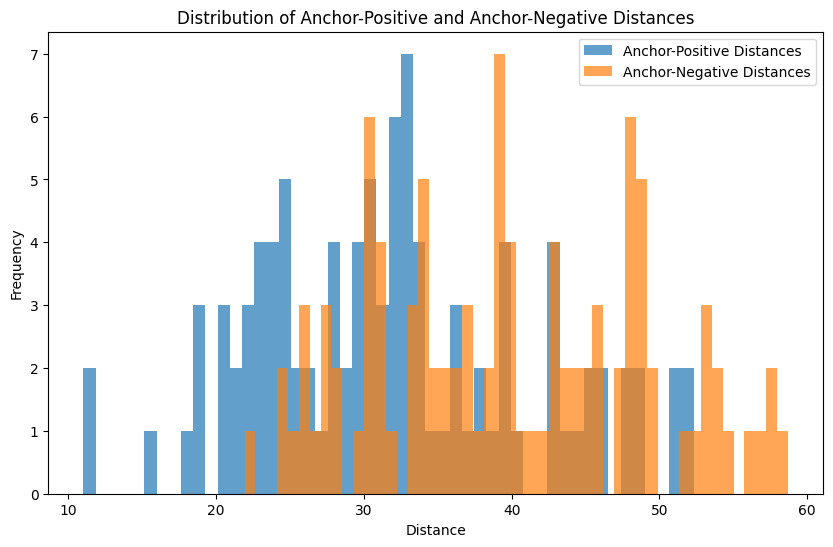

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a batch of triplets for evaluation
# We can use the same TripletGenerator for this, but perhaps with a larger batch size
eval_batch_size = 100 # Use a larger batch size for evaluation
eval_generator = TripletGenerator(dataset_path, gesture_classes, frames_per_video, eval_batch_size)

# Get a batch of data from the generator
eval_data, _ = eval_generator[0]
anchor_images_eval, positive_images_eval, negative_images_eval = eval_data

# Generate embeddings for the evaluation images
anchor_embeddings_eval = embedding_model.predict(anchor_images_eval)
positive_embeddings_eval = embedding_model.predict(positive_images_eval)
negative_embeddings_eval = embedding_model.predict(negative_images_eval)

# Calculate Euclidean distances
pos_distances = np.linalg.norm(anchor_embeddings_eval - positive_embeddings_eval, axis=-1)
neg_distances = np.linalg.norm(anchor_embeddings_eval - negative_embeddings_eval, axis=-1)

# Visualize the distance distributions
plt.figure(figsize=(10, 6))
plt.hist(pos_distances, bins=50, alpha=0.7, label='Anchor-Positive Distances')
plt.hist(neg_distances, bins=50, alpha=0.7, label='Anchor-Negative Distances')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.title('Distribution of Anchor-Positive and Anchor-Negative Distances')
plt.legend()
plt.show()

### **Generate Embeddings for Classification**

In [ ]:
# 1. Create a list of all image file paths and their corresponding labels
all_image_paths = []
all_image_labels = []

for gesture_class in gesture_classes:
    class_dir = os.path.join(dataset_path, gesture_class)
    for video_folder in sorted(os.listdir(class_dir)):
        video_dir = os.path.join(class_dir, video_folder)
        for frame_path in glob.glob(os.path.join(video_dir, "*.png")):
            all_image_paths.append(frame_path)
            all_image_labels.append(gesture_class)

# 2. Load and preprocess each image
preprocessed_images = []
for image_path in all_image_paths:
    img = train_generator._load_image(image_path) # Use the existing _load_image function
    if img is not None:
        preprocessed_images.append(img)
    else:
        # Handle cases where an image failed to load, e.g., remove the corresponding label
        index_to_remove = all_image_paths.index(image_path)
        all_image_labels.pop(index_to_remove)


# 3. Convert the list of preprocessed images into a NumPy array
preprocessed_images_np = np.array(preprocessed_images)

# 4. Use the trained embedding_model to predict the embeddings
image_embeddings = embedding_model.predict(preprocessed_images_np)

# 5. Convert the list of labels into a NumPy array
image_labels_np = np.array(all_image_labels)

print(f"Shape of image embeddings: {image_embeddings.shape}")
print(f"Shape of image labels: {image_labels_np.shape}")

30/30 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step
Shape of image embeddings: (960, 64)
Shape of image labels: (960,)


### **Dataset Prepare Data for Classifier(Split into train/test)**

In [ ]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    image_embeddings, image_labels_np, test_size=0.25, random_state=42
)

# Print the shapes of the resulting sets
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train: (720, 64)
Shape of X_test: (240, 64)
Shape of y_train: (720,)
Shape of y_test: (240,)


### **Train using SVM**

In [ ]:
from sklearn.svm import SVC

# Instantiate an SVC classifier
# Using probability=True allows for probability prediction if needed later
svm_classifier = SVC(kernel='rbf', probability=True, random_state=42)

# Train the SVC model on the training data
svm_classifier.fit(X_train, y_train)

print("SVC classifier training complete.")

SVC classifier training complete.


### **Evaluate the Classifier**

In [ ]:
from sklearn.metrics import accuracy_score

# 1. Use the trained svm_classifier to make predictions on the test set of embeddings
y_pred = svm_classifier.predict(X_test)

# 3. Calculate the accuracy of the classifier's predictions
accuracy = accuracy_score(y_test, y_pred)

# 4. Print the calculated accuracy score
print(f"Accuracy of the SVC classifier on the test set: {accuracy:.4f}")

Accuracy of the SVC classifier on the test set: 0.9917


### **Confusion matrix**

<Figure size 1000x800 with 0 Axes>

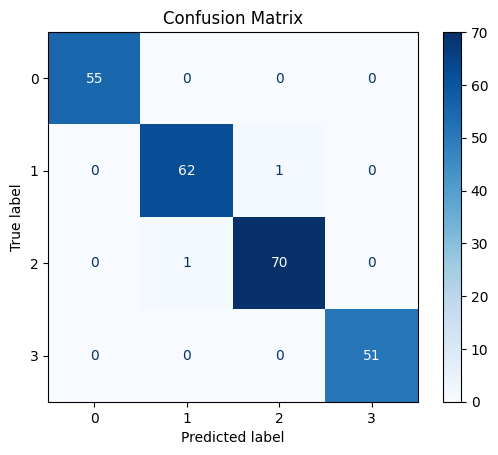

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.unique(y_test))

# Create a ConfusionMatrixDisplay object
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

### **Result visualize (Accuracy, F1 score, Precision and recall score)**

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

# Use the trained svm_classifier to make predictions on the test set of embeddings
y_pred = svm_classifier.predict(X_test)

# Calculate the accuracy of the classifier's predictions
accuracy = accuracy_score(y_test, y_pred)

# Calculate the F1 score
f1 = f1_score(y_test, y_pred, average='weighted')

# Calculate the precision
precision = precision_score(y_test, y_pred, average='weighted')

# Calculate the recall
recall = recall_score(y_test, y_pred, average='weighted')

# Print the calculated metrics
print(f"Accuracy of the SVC classifier on the test set: {accuracy:.4f}")
print(f"F1 Score of the SVC classifier on the test set: {f1:.4f}")
print(f"Precision of the SVC classifier on the test set: {precision:.4f}")
print(f"Recall of the SVC classifier on the test set: {recall:.4f}")

Accuracy of the SVC classifier on the test set: 0.9917
F1 Score of the SVC classifier on the test set: 0.9917
Precision of the SVC classifier on the test set: 0.9917
Recall of the SVC classifier on the test set: 0.9917


### **Save the Trained Model**

In [ ]:
# Define the path where you want to save the model
model_save_path = "/content/drive/MyDrive/siamese_gesture_recognizer.keras" # Or choose a different path

# Save the trained Siamese model
siamese_model.save(model_save_path)

print(f"Trained model saved successfully to: {model_save_path}")

Trained model saved successfully to: /content/drive/MyDrive/siamese_gesture_recognizer.keras
